# Diversity Condition Violated Correct Model

This is a notebook that performs the experiment when the diversity condition is violated and we select a correct model to adjust for that.

- $p(\tilde{z}|z) = \delta(u - u') \frac{e^{\kappa}\tilde{z}^{T}z}{\int_{W(z)}e^{\kappa z^{T}z'}dz'}$ - model conditional density
- $q_{h}(\tilde{z}|z) = \delta(u-u') \frac{e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z)}}{\int_{W(z)}e^{\frac{1}{\tau}h(z)^{T}h(z')}dz'}$ - Model conditional density

The loss function in this setup will be the following:

$\mathcal{L} = \mathbb{E}_{(z, \tilde{z}) \sim p(z, \tilde{z}), \{z^{-}_{i}\} \sim U(\mathcal{W}(z)) }[- \log(\frac{e^{\frac{1}{\tau}h(\tilde{z})^{T}h(z)}}{\Sigma_{i=1}^{M}e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z^{-}_{i})}})]$

The plan is to do the experiments with the following data generating processess:

- 

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

import torch
from torch import nn
from torch import functional

from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side, scatter3d_sphere
import matplotlib.pyplot as plt
from evals.disentanglement import linear_disentanglement, permutation_disentanglement
from visualization_utils.scoring import plot_scores

from simclr.simclr import SimCLRAdjusted

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)

d_fix = 1
d = 3
tau = 0.3
kappa = 1 / tau
batch_size = 2000
neg_samples = 1000
iterations = 5000

# Sampling negative samples in the case where the model of the latent space has violated diversity condition, but our model adjusts for that
def sample_negative_samples(Z, M):
    z_fixed = Z[:, :d_fix].to(device)

    radii = torch.sqrt(1 - (z_fixed ** 2).sum(dim=1)).to(device)  # Radius of the sub-sphere
    neg_samples = torch.randn(Z.shape[0], M, d - d_fix, device=device)

    neg_samples = neg_samples / (neg_samples.norm(dim=2, keepdim=True) + 1e-8)  # Normalize the samples + add some margin for error
    neg_samples = neg_samples * radii.view(-1, 1, 1)

    return torch.cat((z_fixed.unsqueeze(1).expand(-1, M, -1), neg_samples), dim=2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:, :u_dim].to(device)
    v = z[:, u_dim:].to(device)

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2).to(device)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch).to(device) * torch.norm(v, p=2, dim=-1, keepdim=True).to(device)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch).to(device)  # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)

sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, d_fix)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using device:", device)

torch.cuda.empty_cache()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Visualizing the sampling processess

- Uniform Sampling
- Conditional Sampling
- Negative sample sampling

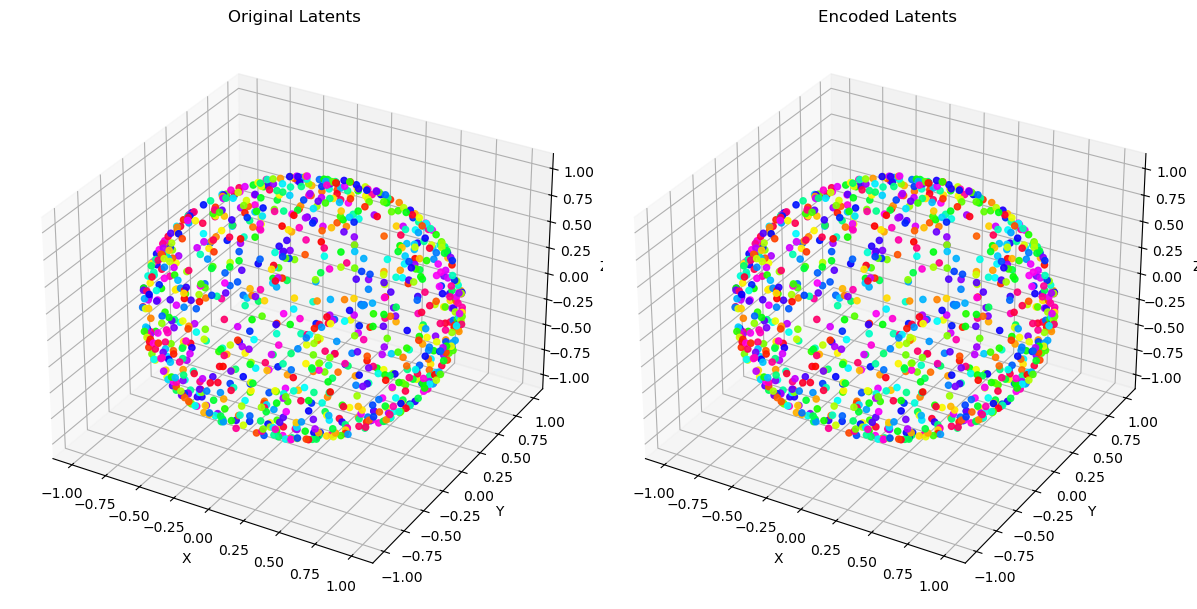

In [2]:
## Uniform sampling

s = full_sphere.uniform(1000)

visualize_spheres_side_by_side(plt, s, s)

tensor([-0.6132, -0.7889,  0.0403])


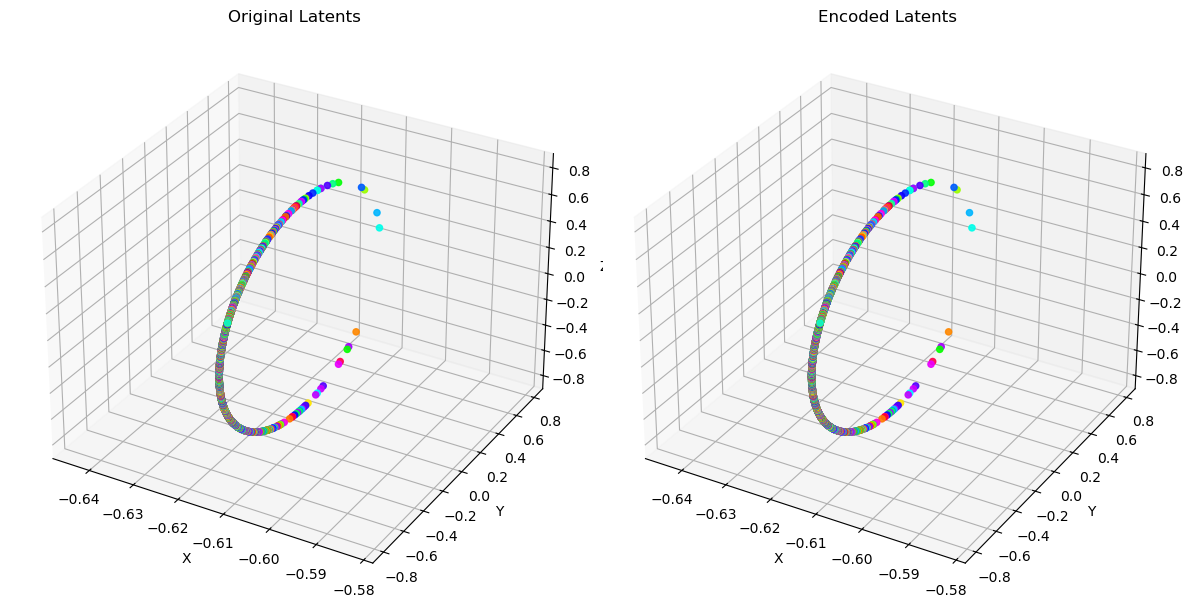

In [3]:
## Visualizing similar sample sampling

z = full_sphere.uniform(1).squeeze(0)

print(z)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, 2000) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(2000, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

z shape: tensor([[ 0.4045, -0.9045,  0.1348]])
SHAPE OF NEGATIVE SAMPLES torch.Size([1000, 3])
MAX tensor(1.0000, device='cuda:0')
MIN tensor(1.0000, device='cuda:0')


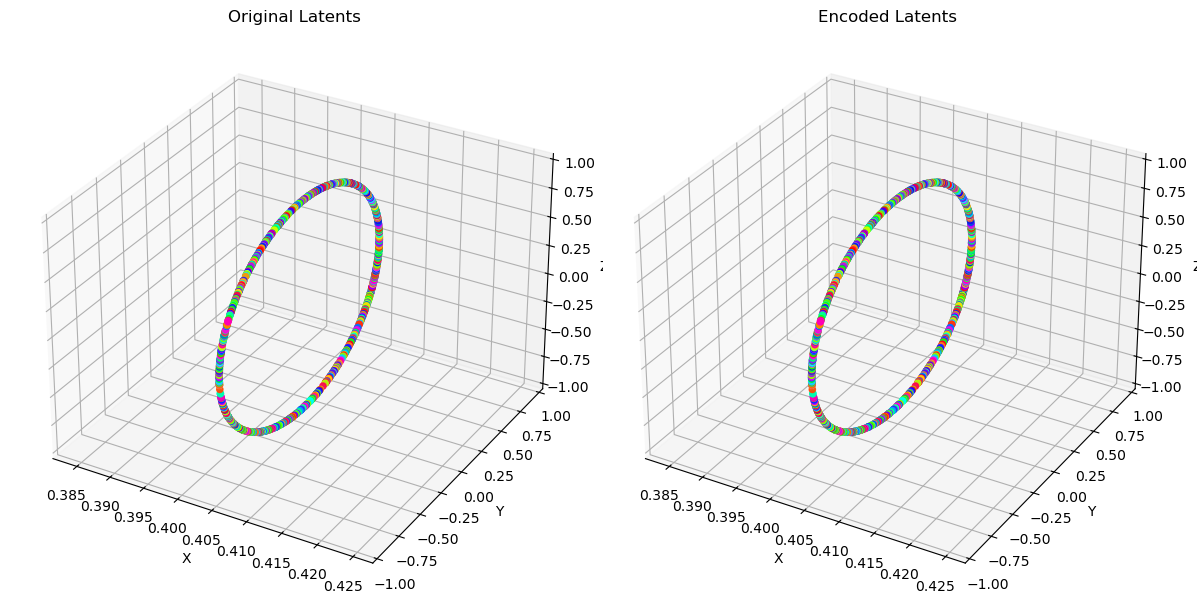

In [4]:
## Visualizing the negative sample sampling

z = full_sphere.uniform(1)

print("z shape:", z)

negative_samples = sample_negative_samples(z, 1000).squeeze(0)

print('SHAPE OF NEGATIVE SAMPLES', negative_samples.shape)
print("MAX", (negative_samples ** 2).sum(dim=1).max())
print("MIN", (negative_samples ** 2).sum(dim=1).min())

visualize_spheres_side_by_side(plt, negative_samples, negative_samples)

In [ ]:
from encoders import SphericalEncoder
from simclr.simclr import SimCLRAdjusted


torch.cuda.empty_cache()

f = SphericalEncoder(input_dim=3, hidden_dims=[128, 256, 256, 256, 256, 256, 256, 128], output_dim=3)
g_id = nn.Identity()


# def __init__(self, d, d_fix, neg_samples, decoder, encoder, sample_pair, sample_negative, tau=0.1, device=None):
f, scores = SimCLRAdjusted(d, d_fix, neg_samples, g_id, f, sample_pair_fixed, sample_negative_samples, tau, device).train(batch_size, iterations)

plot_scores(plt, scores)


# # Initialize the multi-layer perceptron used for encoding
# f_constrained_id = get_mlp(
#     n_in=3,
#     n_out=3,
#     layers=[
#         3 * 10,
#         3 * 50,
#         3 * 50,
#         3 * 50,
#         3 * 50,
#         3 * 10,
#     ],
#     output_normalization="fixed_sphere",
# ).to("cpu")

# g_id = nn.Identity()

# sim_clr_identity = SimCLRAdjusted(
#     d=d,
#     d_fix=d_fix,
#     neg_samples=neg_samples,
#     decoder=g_id,
#     encoder=f_constrained_id,
#     sample_pair=sample_pair_fixed,
#     sample_negative=sample_negative_samples,
#     tau=tau,
#     device=device
# )

# f_constrained_id, scores = sim_clr_identity.train(
#     batch_size=batch_size,
#     iterations=iterations,
# )

# torch.cuda.empty_cache()

# plot_scores(plt, scores)

# h_constrained = lambda z: f_constrained_id(g_id(z))

# z = full_sphere.uniform(1000)
# z_enc = h_constrained(z).to(device)

# visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

# z = full_sphere.uniform(100000)
# z_enc = h_constrained(z).to(device)

# fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
# fig = scatter3d_sphere(plt, z.cpu(), z_enc.cpu(), s=10, a=.8)

In [13]:
from data.generation import InjectiveLinearDecoder
from encoders import construct_mlp_encoder

def perform_linear_experiment(data_dim):
    g_linear = InjectiveLinearDecoder(3, data_dim)
    f = construct_mlp_encoder(data_dim, 3)

    sim_clr_4d = SimCLRAdjusted(
        d=d,
        d_fix=d_fix,
        neg_samples=neg_samples,
        decoder=g_linear,
        encoder=f,
        sample_pair=sample_pair_fixed,
        sample_negative=sample_negative_samples,
        tau=tau,
        device=device
    )

    f, scores = sim_clr_4d.train(
        batch_size=batch_size,
        iterations=iterations,
    )
    torch.cuda.empty_cache()

    plot_scores(plt, scores)

    h = lambda z: f(g_linear(z))
    z = full_sphere.uniform(1000).to(device)
    z_enc = h(z)

    visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())


    z = full_sphere.uniform(100000).to(device)
    z_enc = h(z)
    
    fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
    fig = scatter3d_sphere(plt, z.cpu(), z_enc.cpu(), s=10, a=.8)


In [ ]:
torch.cuda.empty_cache()
perform_linear_experiment(4)

In [ ]:
torch.cuda.empty_cache()
perform_linear_experiment(5)

In [ ]:
torch.cuda.empty_cache()
perform_linear_experiment(6)

In [ ]:
from data.generation import SpiralRotation

f_spiral = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

g_spiral = SpiralRotation(2)

sim_clr_spiral = SimCLRAdjusted(
    d=d,
    d_fix=d_fix,
    neg_samples=neg_samples,
    decoder=g_spiral,
    encoder=f_spiral,
    sample_pair=sample_pair_fixed,
    sample_negative=sample_negative_samples,
    tau=tau,
    device=device
)


f_spiral, scores = sim_clr_spiral.train(batch_size=batch_size, iterations=iterations)
torch.cuda.empty_cache()

plot_scores(plt, scores)

h = lambda z: f_spiral(g_spiral(z))
z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())
